# Test Suite Setup

In [ ]:
%pip install requests
%pip install matplotlib

In [18]:
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import matplotlib.pyplot as plt

In [3]:
home_url = "http://localhost:8080/api/web-service/"
status_url = f"{home_url}/status"
predict_url = f"{home_url}/predict"

def make_request(url, params = {}):
  return requests.get(url = url, params = params)


In [4]:
def assert_condition(name, actual, expected):
  if type(expected) == type(lambda x: x): # Allow for custom assertions
    if expected(actual):
      return None
    else:
      return f'"{name}" - Got "{actual}, which does not satisfy the condition"'

  if actual == expected: # Check for equality
    return None
  else:
    return f'"{name}" - Expected: "{expected}" but got "{actual}"'

def test_request(url, params, expected_status_code, expected_content):
  response = make_request(url, params)

  test_result = [
    assert_condition("status_code", response.status_code, expected_status_code),
    assert_condition("content", response.content.decode(), expected_content)
  ]

  return list(filter(lambda x: x != None, test_result)) # Filter out successful tests

In [5]:
def perform_tests(tests):
  failed_tests = 0
  for test_name, test in tests.items():
    test_result = test_request(test["url"], test["params"], test["expected_status_code"], test["expected_content"])

    if len(test_result) > 0:
      print(f'Test "{test_name}" failed: {test_result}')
      failed_tests += 1
    else:
      print(f'Test "{test_name}" passed!')

  if failed_tests > 0:
    raise AssertionError(f"{failed_tests} test(s) failed!")

# Unit Tests

In [6]:
tests = {
  "home": { # Check the the home route produces the expected content
    "url": home_url,
    "params": {},
    "expected_status_code": 200,
    "expected_content": "To predict, provide an input! \n For example --> http://localhost:8080/api/web-service/predict?input=help"
  },
  "status": { # Check the status route produces a 200 response
    "url": status_url,
    "params": {},
    "expected_status_code": 200,
    "expected_content": "OK"
  },
  "predict_simple": { # Perform a prediction and just check that the response is not empty
    "url": status_url,
    "params": {"input": "hello"},
    "expected_status_code": 200,
    "expected_content": lambda content: len(content) > 0
  },
  "predict_love": { # Perform a prediction and check that the response is "love"
    "url": predict_url,
    "params": {"input": "I love you"},
    "expected_status_code": 200,
    "expected_content": "love"
  },
  "predict_anger": { # Perform a prediction and check that the response is "anger"
    "url": predict_url,
    "params": {"input": "I hate you"},
    "expected_status_code": 200,
    "expected_content": "anger"
  },
  "predict_no_input": { # Check that the correct message is returned when no input field is provided
    "url": predict_url,
    "params": {},
    "expected_status_code": 200,
    "expected_content": "Please provide an input! \n For example --> http://localhost:8080/api/web-service/predict?input=help"
  },
  "predict_empty_input": { # Check that the correct message is returned when an empty input field is provided
    "url": predict_url,
    "params": {"input": ""},
    "expected_status_code": 200,
    "expected_content": "Please provide an input! \n For example --> http://localhost:8080/api/web-service/predict?input=help"
  },
  "predict_non_letter_chars": { # Check that non-letter characters are handled correctly
    "url": predict_url,
    "params": {"input": ".4@]/"},
    "expected_status_code": 200,
    "expected_content": "neutral"
  },
}

perform_tests(tests)

Test "home" passed!
Test "status" passed!
Test "predict_simple" passed!
Test "predict_love" passed!
Test "predict_anger" passed!
Test "predict_no_input" passed!
Test "predict_empty_input" passed!
Test "predict_non_letter_chars" passed!


In [7]:
# ONLY run if new model has been trained, otherwise the default model will be used
# and these tests will not be representative of the new model

new_model_tests = {
  "predict_simple_new_model": { # Perform a prediction with the new model and just check that the response is not empty
    "url": status_url,
    "params": {"input": "hello", "type": "new"},
    "expected_status_code": 200,
    "expected_content": lambda content: len(content) > 0
  },
  "predict_love_new_model": { # Perform a prediction with the new model and check that the response is "love"
    "url": predict_url,
    "params": {"input": "I love you", "type": "new"},
    "expected_status_code": 200,
    "expected_content": "love"
  },
  "predict_anger_new_model": { # Perform a prediction with the new model and check that the response is "anger"
    "url": predict_url,
    "params": {"input": "I hate you", "type": "new"},
    "expected_status_code": 200,
    "expected_content": "anger"
  },
  "predict_no_input_new_model": { # Check that the correct message is returned when no input field is provided to the new model
    "url": predict_url,
    "params": {"type": "new"},
    "expected_status_code": 200,
    "expected_content": "Please provide an input! \n For example --> http://localhost:8080/api/web-service/predict?input=help"
  },
  "predict_empty_input_new_model": { # Check that the correct message is returned when an empty input field is provided to the new model
    "url": predict_url,
    "params": {"input": "", "type": "new"},
    "expected_status_code": 200,
    "expected_content": "Please provide an input! \n For example --> http://localhost:8080/api/web-service/predict?input=help"
  },
  "predict_non_letter_chars_new_model": { # Check that non-letter characters are handled correctly
    "url": predict_url,
    "params": {"input": ".4@]/", "type": "new"},
    "expected_status_code": 200,
    "expected_content": "neutral"
  },
}

perform_tests(new_model_tests)

Test "predict_simple_new_model" passed!
Test "predict_love_new_model" passed!
Test "predict_anger_new_model" passed!
Test "predict_no_input_new_model" passed!
Test "predict_empty_input_new_model" passed!
Test "predict_non_letter_chars_new_model" passed!


# Performance Testing

In [30]:
def perf_test_route(url, params = {}, num_requests = 1000):
  def perf_function():
    start_time = time.perf_counter()
    result = make_request(url, params)
    end_time = time.perf_counter()

    return result, end_time - start_time

  with ThreadPoolExecutor(max_workers = 8) as executor:
    futures = [executor.submit(perf_function) for _ in range(num_requests)]
    responses = [future.result() for future in as_completed(futures)]

  assert all([response[0].status_code == 200 for response in responses]), "Not all requests were successful!"

  response_times = [response[1] for response in responses]

  print(f"Fastest response time: {min(response_times)} seconds")
  print(f"Average response time: {sum(response_times) / len(response_times)} seconds")
  print(f"Slowest response time: {max(response_times)} seconds")

  plt.hist(response_times)
  plt.show()

Fastest response time: 0.014539700001478195 seconds
Average response time: 0.04144806730025448 seconds
Slowest response time: 0.13787419997970574 seconds


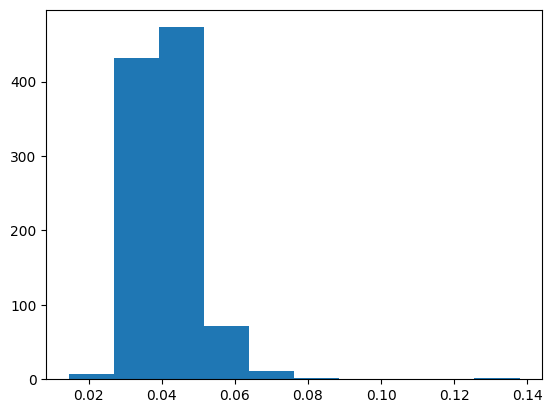

In [31]:
perf_test_route(home_url)

Fastest response time: 0.02739350000047125 seconds
Average response time: 0.04849159680033335 seconds
Slowest response time: 0.14044099999591708 seconds


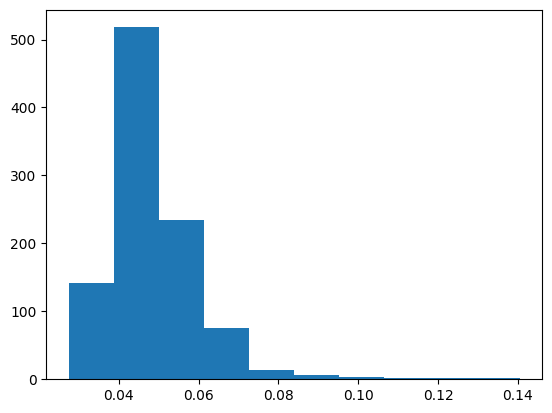

In [32]:
perf_test_route(status_url)

Fastest response time: 0.7824838000233285 seconds
Average response time: 1.3614837873003562 seconds
Slowest response time: 10.450242099992465 seconds


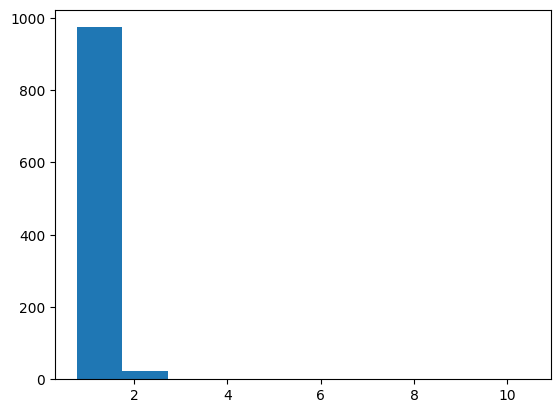

In [33]:
perf_test_route(predict_url, {"input": "hello"})

Fastest response time: 0.8106229999975767 seconds
Average response time: 1.3434211086005088 seconds
Slowest response time: 9.353740699996706 seconds


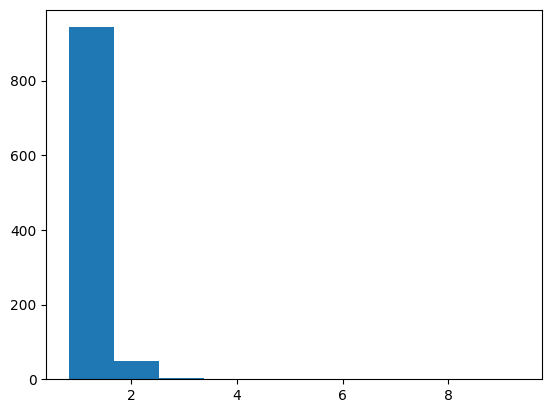

In [34]:
perf_test_route(predict_url, {"input": "this is a longer message than last time to test if the response time is affected by the length of the input"})